The full system of equations discretized with Euler's method is:

$$
\begin{align}
v^{n+1} & = v^n + \Delta t \left(- g\, \sin\theta^n - \frac{C_D}{C_L} \frac{g}{v_t^2} (v^n)^2 \right) \\
\theta^{n+1} & = \theta^n + \Delta t \left(- \frac{g}{v^n}\,\cos\theta^n + \frac{g}{v_t^2}\, v^n \right) \\
x^{n+1} & = x^n + \Delta t \, v^n \cos\theta^n \\
y^{n+1} & = y^n + \Delta t \, v^n \sin\theta^n.
\end{align}
$$

As we've learned before, the system of differential equations can also be written as a vector equation:

$$
u'(t) = f(u)
$$

where

$$
\begin{align}
u & = \begin{pmatrix} v \\ \theta \\ x \\ y \end{pmatrix} & f(u) & = \begin{pmatrix} - g\, \sin\theta - \frac{C_D}{C_L} \frac{g}{v_t^2} v^2 \\ - \frac{g}{v}\,\cos\theta + \frac{g}{v_t^2}\, v \\ v\cos\theta \\ v\sin\theta \end{pmatrix}
\end{align}
$$

It's a bit tricky to code the solution using a NumPy array holding all your independent variables. But if you do, a function for the Euler step can be written that takes any number of simultaneous equations. It simply steps in time using the same line of code:

```Python
def euler_step(u, f, dt):
    return u + dt * f(u)
```

This function can take a NumPy array `u` with any number of components. All we need to do is create an appropriate function `f(u)` describing our system of differential equations. Notice how we are passing a _function_ as part of the arguments list to `euler_step()`. Neat!

In [2]:
import math #here using math operations to calculate f(u) components is easier than numpy operations
import numpy
from matplotlib import pyplot
%matplotlib inline 
#to plot the plot in line with the notebook instead of default popups

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
# Set parameters.
g = 9.81  # gravitational acceleration (m.s^{-2})
vt = 30.0  # trim velocity (m.s)
CD = 1.0 / 40  # drag coefficient
CL = 1.0  # lift coefficient

# Set initial conditions.
v0 = vt  # start at the trim velocity
theta0 = 0.0  # trajectory angle
x0 = 0.0  # horizontal position
y0 = 1000.0  # vertical position (altitude)

In [5]:
def rhs_phugoid(u, CL, CD, g, vt):
    """
    Returns the right-hand side of the phugoid system of equations.
    
    Parametersb
    ----------
    u : list or numpy.ndarray
        Solution at the previous time step
        as a list or 1D array of four floats.
    CL : float
        Lift coefficient.
    CD : float
        Drag coefficient.
    g : float
        Gravitational acceleration.
    vt : float
        Trim velocity.
    
    Returns
    -------
    rhs : numpy.ndarray
        The right-hand side of the system
        as a 1D array of four floats.
    """
    v, theta, x, y = u
    rhs = numpy.array([-g * math.sin(theta) - CD / CL * g / vt**2 * v**2,
                       -g * math.cos(theta) / v + g / vt**2 * v,
                       v * math.cos(theta),
                       v * math.sin(theta)])
    return rhs

In [6]:
def euler_step(u, f, dt, *args):
    
    # *args allows one to enter any number of arguments to the function instead of a defined fixed number
    
    """
    Returns the solution at the next time step using Euler's method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u + dt * f(u, *args)
    return u_new

In [7]:
T = 1000.0  # length of the time interval
dt = 0.1  # time-step size
N = int(T / dt) + 1  # number of time steps

# Create array to store the solution at each time step.
u = numpy.empty((N, 4))
# Set the initial conditions.
u[0] = numpy.array([v0, theta0, x0, y0])

# u is a numpy array of v, theta, x, y values for all N grid points. 

# Time integration with Euler's method.
for n in range(N - 1): #here N-1 because the indexing starts from 0, so total is (N-1 - 0 + 1)
    u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)

Here u has the following structure: 

              v 0 x y
              | | | |  
     u =    [ . . . .,
              . . . .,
              . . . .,
              -
              -
              -
              . . . . ]
                       (N, 4)
                       
The number of rows in the numpy array u is N, corresponding to the values of the four variables, v, theta, x, y at all the grid points. 

In [8]:
# Get the glider's position over the time.

# Fancy indexing used here

x = u[:, 2] # u[row indexing, column indexing] => u[all rows, col 3], col 3 corrsponds to x values
y = u[:, 3] # u[row indexing, column indexing] => u[all rows, col 4], col 4 corrsponds to y values
print(x, y)

[0.00000000e+00 3.00000000e+00 5.99754750e+00 ... 2.99771717e+04
 2.99801769e+04 2.99831825e+04] [1000.         1000.         1000.         ...  250.34149686  250.2540638
  250.16708739]


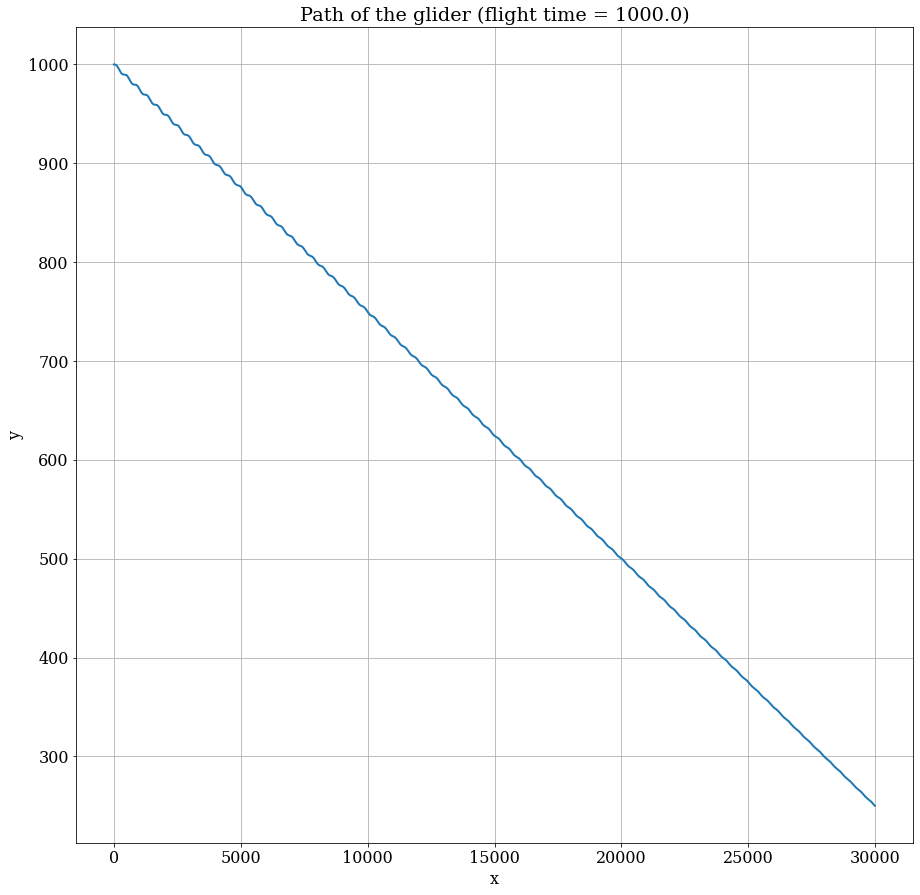

In [9]:
# Plot the path of the glider.
pyplot.figure(figsize=(15.0, 15.0))
pyplot.title('Path of the glider (flight time = {})'.format(T))
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.grid()
pyplot.plot(x, y, color='C0', linestyle='-', linewidth=2);

## Grid Convergence

As this problem has no exact solution, the convergence is determined by the relative error between the output of the finest grid and the coarsest grid. 

In [10]:
# Set the list of time-step sizes.
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

# Create an empty list that will contain the solution of each grid.
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time-steps
    # Create array to store the solution at each time step.
    u = numpy.empty((N, 4))
    # Set the initial conditions.
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Temporal integration using Euler's method.
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    # Store the solution for the present time-step size
    u_values.append(u)

In [11]:
def l1_diff(u_coarse, u_fine, dt):
    """
    Returns the difference in the L1-norm between the solution on
    a coarse grid and the solution on a fine grid.
    
    Parameters
    ----------
    u_coarse : numpy.ndarray
        Solution on the coarse grid as an array of floats.
    u_fine : numpy.ndarray
        Solution on the fine grid as an array of floats.
    dt : float
        Time-step size.
    
    Returns
    -------
    diff : float
        The difference between the two solutions in the L1-norm
        scaled by the time-step size.
    """
    N_coarse = len(u_coarse)
    N_fine = len(u_fine)
    ratio = math.ceil(N_fine / N_coarse) 
    #function .ceil will round the ratio to the immediate upper value
    # eg 1001/101 = 9.9..>> .ceil = 10
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

In [12]:
A = numpy.array([11 , 12, 13, 14, 15])
temp_i = numpy.zeros(5).reshape(5,1)
temp_dt = numpy.zeros(5).reshape(5,1)
print(A[:-1]) 
#this indexing indicates= start from 0th index till the (n-1)th index. Because stop is till the last value (-1 th index), so it will consider all values from 0th index to the (n-1)th index, includuing (n-1)th value
for i, dt in enumerate(A[:-1]):
    temp_i[i] = i
    temp_dt[i] = dt
    
print(temp_i, "\n")
print(temp_dt)
    

[11 12 13 14]
[[0.]
 [1.]
 [2.]
 [3.]
 [0.]] 

[[11.]
 [12.]
 [13.]
 [14.]
 [ 0.]]


In [13]:
A1 = numpy.array([11 , 12, 13, 14, 15])
temp_i1 = numpy.zeros(5).reshape(5,1)
temp_dt1 = numpy.zeros(5).reshape(5,1)
print(A1[:-1]) 
#this indexing indicates= start from 0th index till the (n-1)th index. Because stop is till the last value (-1 th index), so it will consider all values from 0th index to the (n-1)th index, excluding (n-1)th value
for i, dt in enumerate(A1):
    temp_i1[i] = i
    temp_dt1[i] = dt
    
print(temp_i1, "\n")
print(temp_dt1)

[11 12 13 14]
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]] 

[[11.]
 [12.]
 [13.]
 [14.]
 [15.]]


In [14]:
# Create an empty list to store the difference in the solution
# between two consecutive grids.
diff_values = []
# dt_values = [0.1, 0.05, 0.01, 0.005, 0.001] for reference


for i, dt in enumerate(dt_values[:-1]):
    #print(str(u_values[i][:, 2]))
    # u_values[i][:, 2] = all the x vlaues for a partiuclar numerical solution corresponding to a dt value
    # u_values[-1][:, 2] = all the x vlaues for a partiuclar numerical solution corresponding to the last dt value, which is most fine grid
    diff = l1_diff(u_values[i][:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)
print(diff_values)

[892.7736856530105, 142.8385431367841, 17.08436073744036, 7.277358690123211]


the above for loop calculates L1 error between all the u_values[i] (except for the last one) and the u_values for the last dt_value, which is the finest grid, hence the dt_values[:, -1], as we are comparing with the u_values corresponding to the last dt_value, whcih is the finest grid.

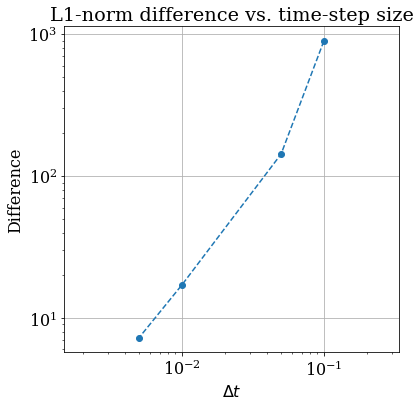

In [15]:
# Plot the difference versus the time-step size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm difference vs. time-step size')  # set the title
pyplot.xlabel('$\Delta t$')  # set the x-axis label
pyplot.ylabel('Difference')  # set the y-axis label
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values,
              color='C0', linestyle='--', marker='o')  # log-log plot
pyplot.axis('equal');  # make axes scale equally

### Order of Convergence

The order of convergence is the rate at which the numerical solution approaches the exact one as the mesh is refined. Considering that we're not comparing with an exact solution, we use 3 grid resolutions that are refined at a constant ratio $r$ to find the *observed order of convergence* ($p$), which is given by:

$$
\begin{equation}
p = \frac{\log \left(\frac{f_3-f_2}{f_2-f_1} \right) }{\log(r)}
\end{equation}
$$

where $f_1$ is the finest mesh solution, and $f_3$ the coarsest. 

In [16]:
r = 2  # refinement ratio for the time-step size
h = 0.001  # base grid size

#defining the dt_values list for h, rh, r^2h
dt_values2 = [h, r * h, r**2 * h]
print(dt_values2)
#initializing u_values2
u_values2 = []

for dt in dt_values2:
    N = int(T / dt) + 1  # number of time steps
    # Create array to store the solution at each time step.
    u = numpy.empty((N, 4))
    # Set initial conditions.
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Time integration using Euler's method.
    for n in range(N - 1): 
    #here N-1 because the indexing starts from 0, so total is (N-1 - 0 + 1)
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    # Store the solution.
    u_values2.append(u)

# Calculate f2 - f1.
f2_f1 = l1_diff(u_values2[1][:, 2], u_values2[0][:, 2], dt_values2[1])
# Calculate f3 - f2.
f3_f2 = l1_diff(u_values2[2][:, 2], u_values2[1][:, 2], dt_values2[2])
# Calculate the observed order of convergence.
p = math.log(f3_f2 / f2_f1) / math.log(r)
print('Observed order of convergence: p = {:.3f}'.format(p))

[0.001, 0.002, 0.004]
Observed order of convergence: p = 1.035


See how the observed order of convergence is close to 1? This means that the rate at which the grid differences decrease match the mesh-refinement ratio. We say that Euler's method is of *first order*, and this result is a consequence of that.